## Testing hypothesis 1 in a Big Data context using PySpark
---

**_Hypothesis_**: Reviews with longer text have higher helpfulness ratings.

   - **Metric**: Correlation coefficient (e.g., Pearson's correlation) between review length and helpfulness ratings. Plot the helpfulness rate as a function of the review length.

- **Missing Values**:

  - `review/text`: set missing values as empty string
  - `review/helpfulness`: remove the entire sample

- **Data Transformation**:

  - `review/text`: Count the number of words in each review removing punctuation and stopwords
  - `review/helpfulness`: $helpfulness = \frac{x}{y} \sqrt(y)$


In [ ]:
# Initialize spark
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("hypothesis_1").getOrCreate()

In [83]:
# Import libraries
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, Bucketizer, Tokenizer, StopWordsRemover
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
import string
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andreaalberti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Define the schema
ratings_schema = StructType([
    StructField("Title", StringType(), True),
    StructField("Price", FloatType(), True),
    StructField("User_id", IntegerType(), True),
    StructField("profileName", StringType(), True),
    StructField("review/score", FloatType(), True),
    StructField("review/time", IntegerType(), True),
    StructField("review/summary", StringType(), True),
    StructField("review/text", StringType(), True),
    StructField("N_helpful", IntegerType(), True),
    StructField("Tot_votes", IntegerType(), True)
])

# Load the data
df_ratings = spark.read.csv('hdfs://localhost:9900/user/book_reviews/books_rating_cleaned.csv', header=True, schema=ratings_schema, sep='\t')
df_ratings.show(5)

In [ ]:
# Filter out the data
df_ratings_filtered = df_ratings.filter(df_ratings['review/text'].isNotNull())
df_ratings_filtered = df_ratings_filtered.filter(df_ratings_filtered['Tot_votes'] > 20)

# Add the helpfulness ratio column
df_ratings_filtered = df_ratings_filtered.withColumn('helpfulness_ratio', df_ratings_filtered['N_helpful']/df_ratings_filtered['Tot_votes']*sqrt(df_ratings_filtered['Tot_votes']))

# Retain only the required columns
df_ratings_selected = df_ratings_filtered.select('review/text', 'helpfulness_ratio')

# Remove punctuation
puncts = string.punctuation
df_ratings_selected = df_ratings_selected.withColumn('review/text', lower(regexp_replace('review/text', r'[!"#$%&\'()*+,-./:;<=>?@\\^_`{|}~]', ' ')))

# Tokenize the text
tokenizer = Tokenizer(inputCol='review/text', outputCol='words')
df_ratings_selected = tokenizer.transform(df_ratings_selected)

# Remove stopwords
remover = StopWordsRemover(inputCol='words', outputCol='words_filtered', stopWords=stopwords)
df_ratings_selected = remover.transform(df_ratings_selected)

# Compute the length of the review
df_ratings_selected = df_ratings_selected.withColumn('review_length', size('words_filtered'))

# Compute the correlation coefficient
vector_col = VectorAssembler(inputCols=['review_length', 'helpfulness_ratio'], outputCol='features')
dataset = vector_col.transform(df_ratings_selected).select('features')
corr = Correlation.corr(dataset, 'features', method='spearman').collect()[0][0].toArray()[0][1]
print(f'The Spearman correlation coefficient is {corr}')

In [84]:
# Split the data into bins
groups = [0, 250, 500, 750, float('Inf')]
bucketizer = Bucketizer(splits=groups, inputCol='review_length', outputCol='review_length_bins')
df_bucketized = bucketizer.transform(df_ratings_selected)

Text(0.5, 1.0, 'Review Length Range vs Helpfulness Rate')

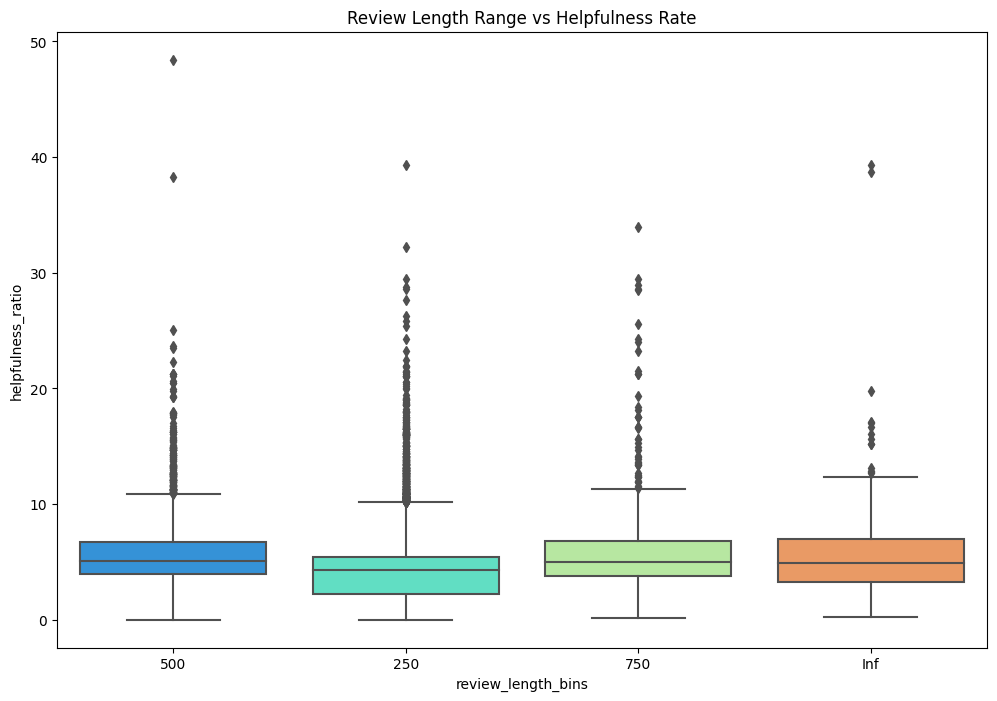

In [85]:
# Create a dictionary to map the bins to the labels
labels = {0: '250', 1: '500', 2: '750', 3: 'Inf'}
assign_labels = udf(lambda x: labels[x], StringType())
df_bucketized = df_bucketized.withColumn('review_length_bins', assign_labels('review_length_bins'))

# Sample the data to show the results with Pandas
df_bucketized_pandas = df_bucketized.sample(False, 0.1).toPandas()
plt.figure(figsize=(12, 8))
sns.boxplot(x='review_length_bins', y='helpfulness_ratio', data=df_bucketized_pandas, palette='rainbow')
plt.title('Review Length Range vs Helpfulness Rate')

Group: 250
Spearman correlation coefficient: 0.3468979003350398



Group: 500
Spearman correlation coefficient: 0.058466527731229616



Group: 750
Spearman correlation coefficient: -0.04023567618819556



Group: inf
Spearman correlation coefficient: -0.09046299582053602



<Figure size 1500x1000 with 0 Axes>

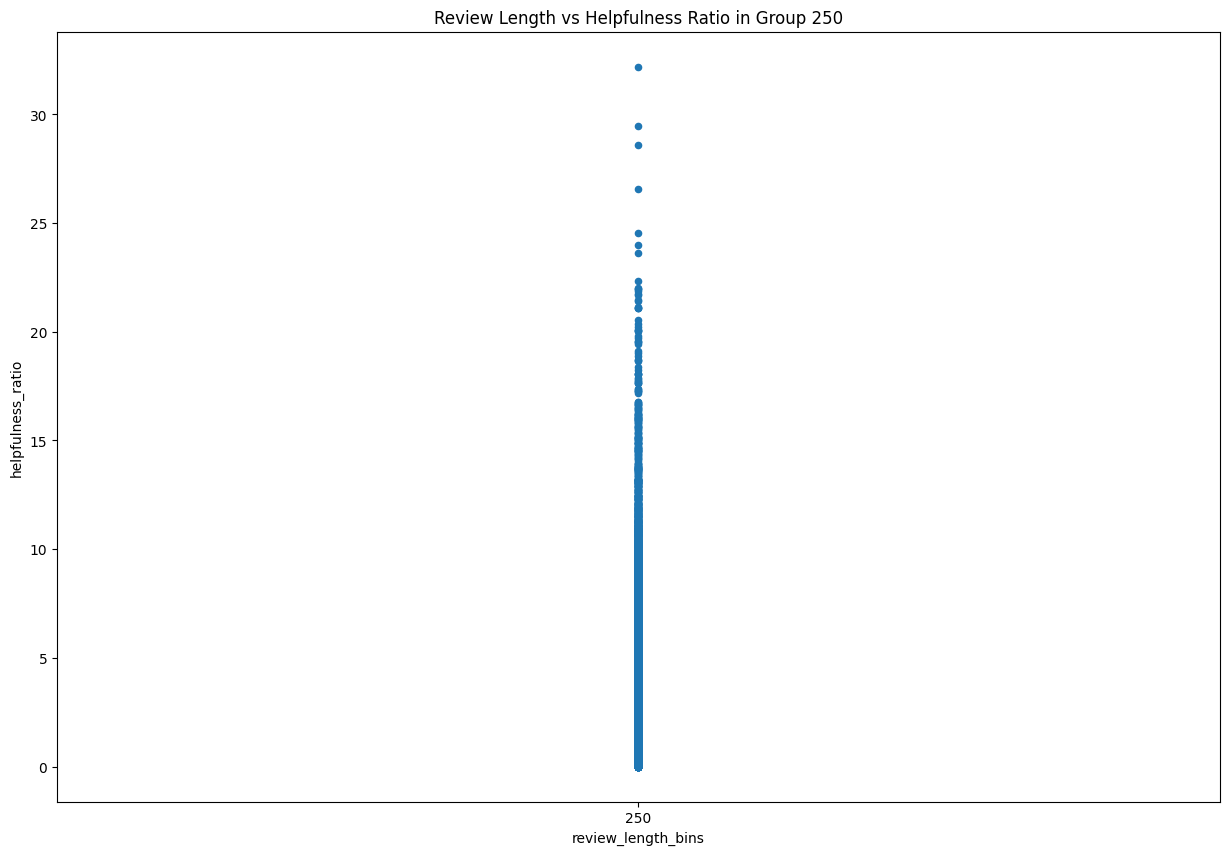

<Figure size 1500x1000 with 0 Axes>

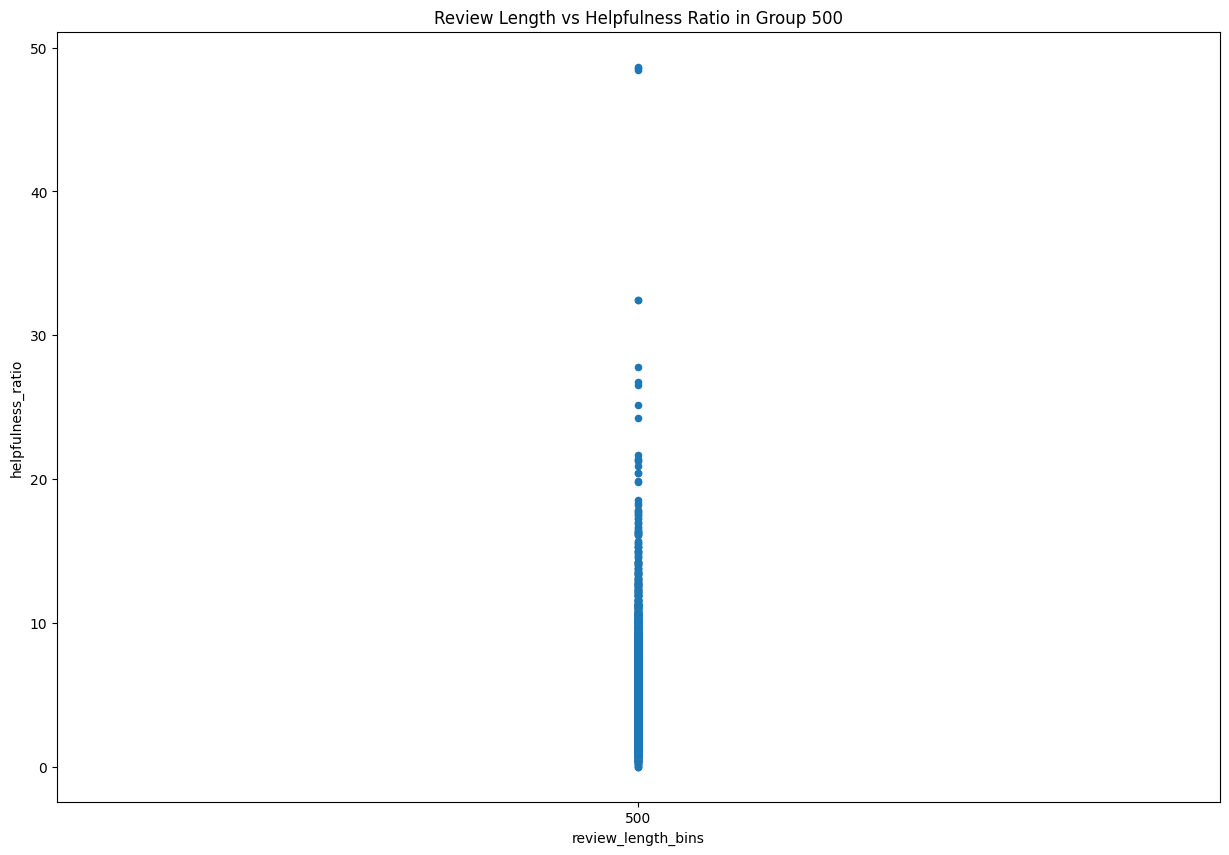

<Figure size 1500x1000 with 0 Axes>

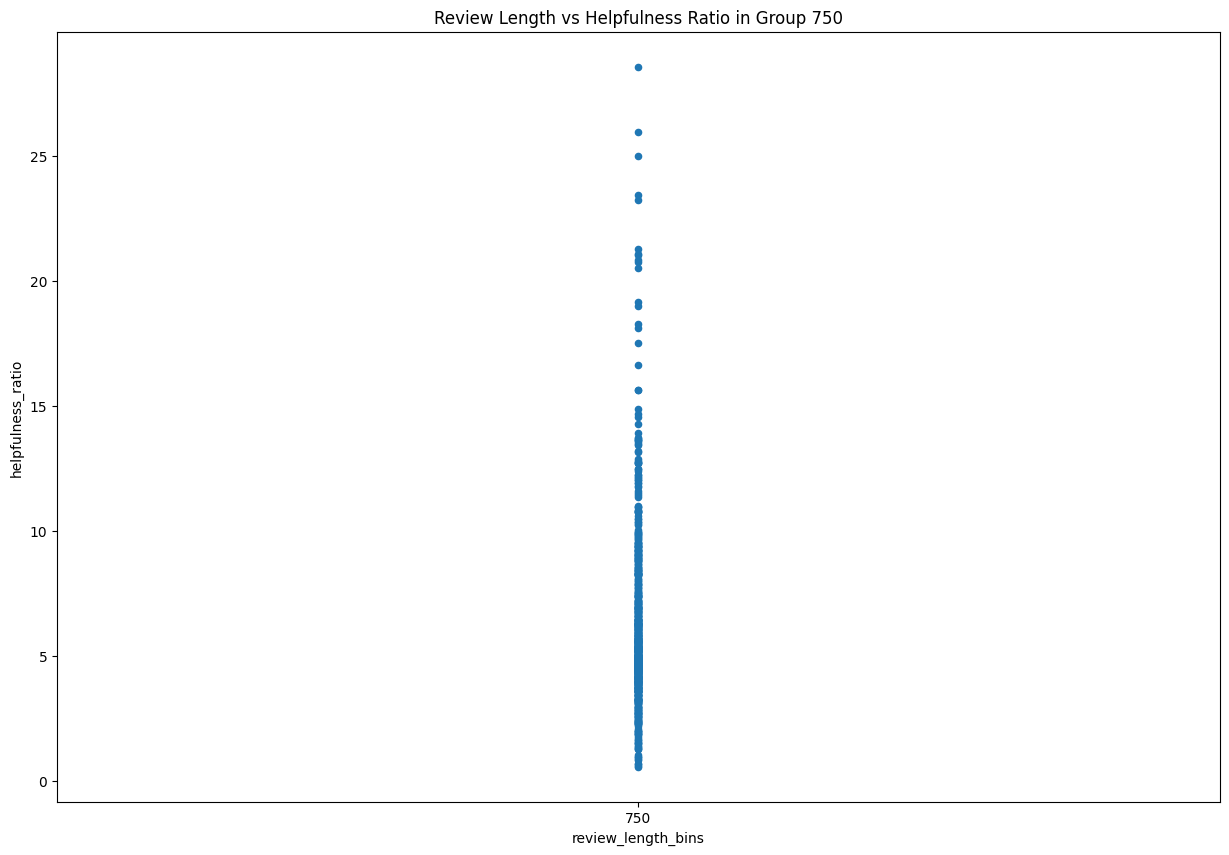

<Figure size 1500x1000 with 0 Axes>

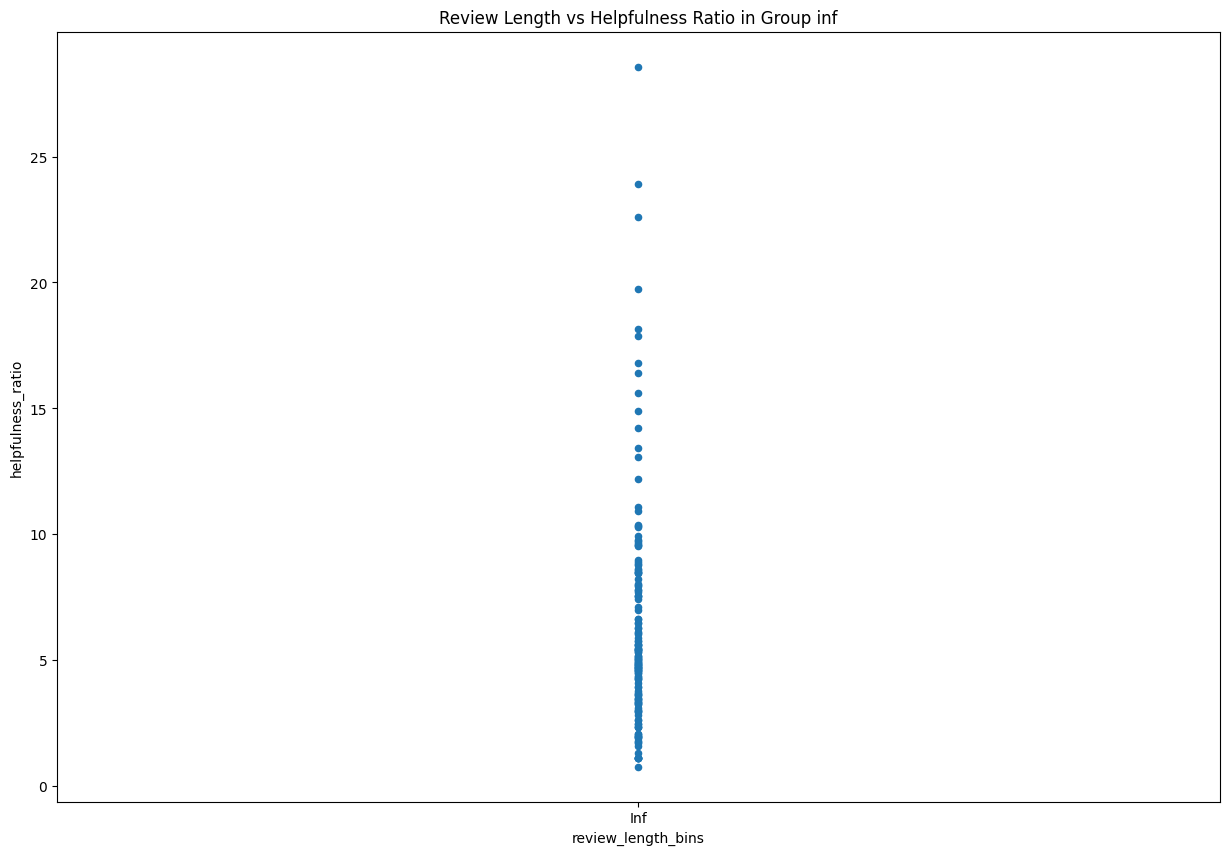

In [86]:
# Compute the correlation coefficient for each group
for el in groups[1:]: 
    df = df_bucketized.filter(df_bucketized['review_length_bins'] == el)
    vector_col = VectorAssembler(inputCols=['review_length', 'helpfulness_ratio'], outputCol='features')
    dataset = vector_col.transform(df).select('features')
    corr = Correlation.corr(dataset, 'features', method='spearman').collect()[0][0].toArray()[0][1]
    print(f'Group: {el}\nSpearman correlation coefficient: {corr}\n')
    df = df.sample(False, 0.1).toPandas()
    plt.figure(figsize=(15,10))
    df.plot(kind='scatter',x='review_length',y='helpfulness_ratio',figsize=(15,10),title=f'Review Length vs Helpfulness Ratio in Group {el}')

NameError: name 'hist' is not defined